# Notebook 1: Análisis Exploratorio y Estrategia del Modelo

**Objetivo:** Este notebook explica el proceso de análisis que nos llevó a la estrategia final de modelado. Replicaremos los gráficos y hallazgos clave que justificaron la decisión de entrenar modelos segmentados por sector económico.

In [1]:
# --- Celda de Código 1 (Versión Corregida) ---

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.oauth2 import service_account
from dotenv import load_dotenv

# --- CAMBIO CLAVE: Aseguramos que estamos en el directorio raíz del proyecto ---
# Verificamos si estamos en la carpeta correcta. Si no, subimos de nivel.
if os.path.basename(os.getcwd()) == 'notebooks_explicativos':
    os.chdir('../../')
print(f"Directorio de trabajo actual: {os.getcwd()}")
# --- FIN DEL CAMBIO ---

# --- Carga de Datos desde BigQuery ---
print("\nCargando datos desde BigQuery...")
load_dotenv() # Ahora encontrará el .env en la raíz sin problemas

GCP_KEY_PATH = os.getenv("GCP_SERVICE_ACCOUNT_KEY_PATH")
PROJECT_ID = "datamanagementbi"
TABLE_ID = "gold_data.modelo_final_v2" 

credentials = service_account.Credentials.from_service_account_file(GCP_KEY_PATH)
query = f"SELECT fecha, id_sector_economico, id_tramo_horario, consumo_kwh FROM `{PROJECT_ID}.{TABLE_ID}`"
df = pd.read_gbq(query, project_id=PROJECT_ID, credentials=credentials, progress_bar_type='console')

# Mapeo de IDs a nombres para los gráficos
sector_map = {1: 'Industrial', 2: 'Residencial', 3: 'Servicios'}
df['sector_nombre'] = df['id_sector_economico'].map(sector_map)
df['fecha'] = pd.to_datetime(df['fecha'])

print("Datos cargados y preparados.")

Directorio de trabajo actual: c:\Users\julic\OneDrive\EAE\DMBI\proyecto\MisProyectosGit\data-management-energy

Cargando datos desde BigQuery...


C:\Users\julic\AppData\Local\Temp\ipykernel_29376\2875950741.py:27: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query, project_id=PROJECT_ID, credentials=credentials, progress_bar_type='console')


Datos cargados y preparados.


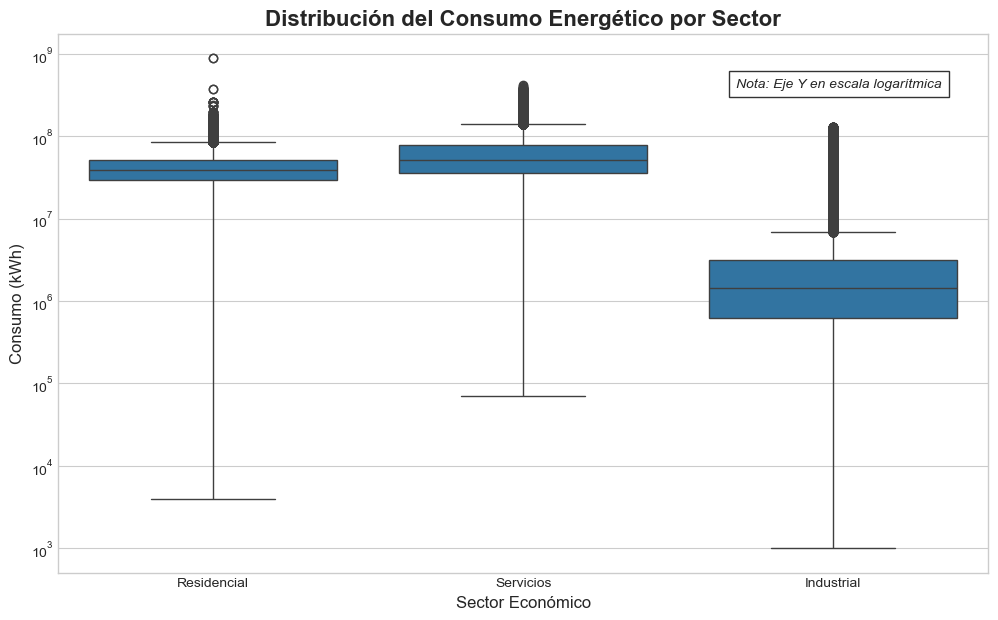

In [2]:
# --- Hallazgo Clave 1: El consumo varía enormemente por sector ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Usamos un boxplot para ver la distribución del consumo en cada sector
sns.boxplot(data=df, x='sector_nombre', y='consumo_kwh', ax=ax)

ax.set_title('Distribución del Consumo Energético por Sector', fontsize=16, fontweight='bold')
ax.set_xlabel('Sector Económico', fontsize=12)
ax.set_ylabel('Consumo (kWh)', fontsize=12)
ax.set_yscale('log') # Usamos escala logarítmica porque las diferencias son muy grandes
ax.text(0.95, 0.90, 'Nota: Eje Y en escala logarítmica', 
        style='italic', transform=ax.transAxes, ha='right',
        bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

plt.show()

**Conclusión del Gráfico 1:** El gráfico de cajas muestra claramente que no solo los niveles de consumo, sino también la variabilidad (el tamaño de las "cajas") son radicalmente diferentes entre los sectores. El sector de **Servicios** tiene el consumo más alto y variable. **Esta fue la primera y más importante señal de que un modelo único para todos los sectores sería impreciso.**

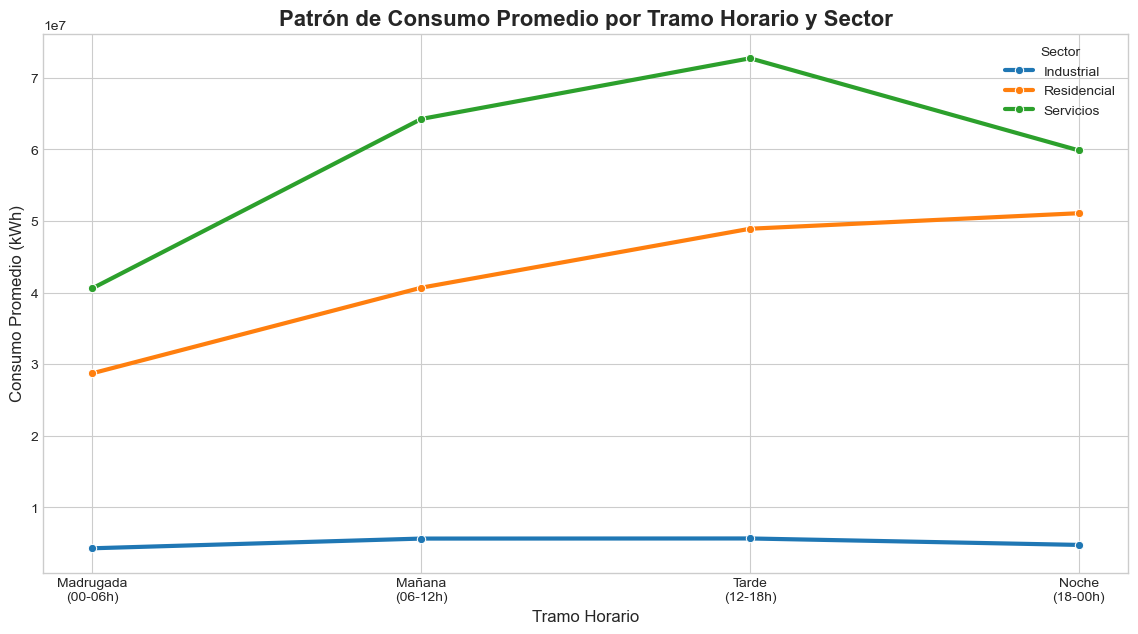

In [3]:
# Celda del Gráfico de Patrón Horario (Versión Final Corregida)

# --- Hallazgo Clave 2: Los patrones horarios son distintos ---
# Agrupamos por 'id_tramo_horario' en lugar de extraer la hora
df_horario = df.groupby(['sector_nombre', 'id_tramo_horario'])['consumo_kwh'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(data=df_horario, x='id_tramo_horario', y='consumo_kwh', hue='sector_nombre', lw=3, marker='o', ax=ax)

# Formateo del gráfico para que sea más claro
ax.set_title('Patrón de Consumo Promedio por Tramo Horario y Sector', fontsize=16, fontweight='bold')
ax.set_xlabel('Tramo Horario', fontsize=12)
ax.set_ylabel('Consumo Promedio (kWh)', fontsize=12)

# Añadimos etiquetas descriptivas al eje X
tramo_labels = {1: 'Madrugada\n(00-06h)', 2: 'Mañana\n(06-12h)', 3: 'Tarde\n(12-18h)', 4: 'Noche\n(18-00h)'}
ax.set_xticks(list(tramo_labels.keys()))
ax.set_xticklabels(list(tramo_labels.values()))

ax.legend(title='Sector')
plt.show()

**Conclusión del Gráfico 2:** Los patrones de consumo diario son completamente diferentes:
- **Residencial:** Muestra dos picos claros, uno por la mañana y otro, mucho más alto, por la noche cuando la gente vuelve a casa.
- **Servicios:** Sigue un patrón de día laboral, aumentando por la mañana, manteniéndose alto durante el día y cayendo por la noche.
- **Industrial:** Es mucho más plano, lo que sugiere una operación más continua.

**Decisión Estratégica Final:** Basado en estas diferencias visuales evidentes, se concluyó que la estrategia más efectiva sería entrenar **un modelo especializado para cada sector**, ya que cada uno obedece a una lógica de consumo distinta.